# Hands-on Machine Learning with Scikit-learn and Tensorflow
## 02 End to end Machine Learning project

This jupyter notebook is just a recitation of the first project in the book [Hands-on Machine Learning with Scikit-Learn and TensorFlow](https://github.com/ageron/handson-ml). I just add custom notes for my own comprehension. But all the credits goes to __Aurélien Géron__. <br>
You can check the official notebook : https://github.com/ageron/handsonml/blob/master/02_end_to_end_machine_learning_project.ipynb.

## Brief
_Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts._

### Imports

In [1]:
import os
import tarfile
from six.moves import urllib
import hashlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

### Constants

In [2]:
# good practices
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml/master/'
HOUSING_PATH = 'datasets/housing'
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + '/housing.tgz'

### Download the data

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, 'housing.tgz')
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [5]:
fetch_housing_data()
housing = load_housing_data()

### The data structure

In [6]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [7]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

### Find categorical attribute

In [9]:
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

### Visualize data

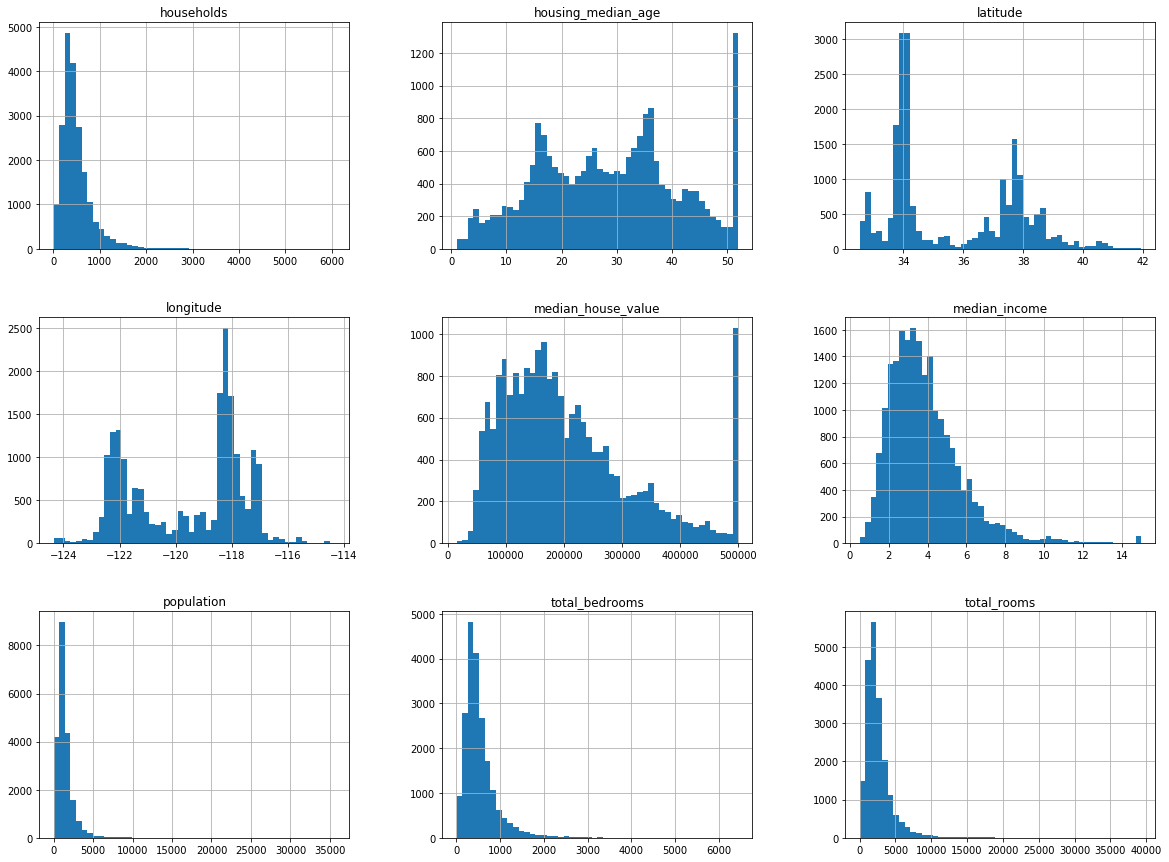

In [10]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

### Create a test set
I find the part of creating a test dataset very useful. I encourage you to read this part in the book (page 77).
#### Why we split the dataset ?
___
_"It may sound strange to voluntarily set aside part of the data at this stage. After all, you have only taken a
quick glance at the data, and surely you should learn a whole lot more about it before you decide what
algorithms to use, right?
This is true, but your brain is __an amazing pattern detection system__, which means
that it is highly prone to overfitting: if you look at the test set, you may stumble upon some seemingly
interesting pattern in the test data that leads you to select a particular kind of Machine Learning model."_ <br>
___

#### Good practice
The better solution to create a test set is to use a __unique and immuable identifier__ for each instance. Also we can compute a hash on each instance's identifier, keep only the last byte of the hash and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). <br>
__This ensures that the test set will remain consistent across multiple runs, even if you
refresh the dataset.__ <br>
In our example, Longitude and Latitude are guaranteed stable, so we could combine them into an ID.

In [11]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [12]:
def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [13]:
housing_with_id = housing.reset_index()
housing_with_id['id'] = housing['longitude'] * 1000 + housing['latitude']

In [14]:
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

### Go further
Here we have considered purely random sampling methods. __Aurélien__ said that it is generally fine if our dataset is large enough. <br>
But in fact, we introduce a biais in our split.
#### Does each instance have a unique couple Longitude/Latitude ?

In [15]:
len(housing[housing.duplicated(subset=['longitude', 'latitude'], keep=False)])

12403

In [16]:
housing[housing.duplicated(subset=['longitude', 'latitude'], keep=False)].sort_values(by=['longitude', 'latitude']).head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
2553    -124.18     40.78                37.0       1453.0           293.0   
2554    -124.18     40.78                33.0       1076.0           222.0   
2555    -124.18     40.78                34.0       1592.0           364.0   
2547    -124.18     40.79                39.0       1836.0           352.0   
2548    -124.18     40.79                40.0       1398.0           311.0   

      population  households  median_income  median_house_value  \
2553       867.0       310.0         2.5536             70200.0   
2554       656.0       236.0         2.5096             72200.0   
2555       950.0       317.0         2.1607             67000.0   
2547       883.0       337.0         1.7450             70500.0   
2548       788.0       279.0         1.4668             64600.0   

     ocean_proximity  
2553      NEAR OCEAN  
2554      NEAR OCEAN  
2555      NEAR OCEAN  
2547      NEAR OCEAN  
2548      NEAR OCEAN

No ! We have different instances that have a same longitude/latitude couple ! Same couple will be in the same set (train or test). <br>
So we have introdious a biais !
#### Solution
We can add features to find a unique identifier.

In [17]:
len(housing[housing.duplicated(subset=[
    'longitude','latitude','housing_median_age'
], keep=False)])

2345

In [18]:
len(housing[housing.duplicated(subset=[
    'longitude','latitude','housing_median_age', 'total_rooms'
], keep=False)])

2

In [19]:
len(housing[housing.duplicated(subset=[
    'longitude','latitude','housing_median_age', 'total_rooms', 'total_bedrooms'
], keep=False)])

0

I think with this features : longitude, latitude, housing_median_age, total_rooms and total_bedrooms, we really have an unique identifier. We can hash each instance and split it to have a train and test set without biais. <br>
_Note : If you provide more examples to dataset in the future, we need to be sure of the difference between each instances. Maybe we need to take all features._ <br>
__If you are reading this jupyter notebook, I will appreciate if you help me to be more certain about it__